#### Import / Global Vars

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Global variables
log = True
refresh_pricing = False
universe = 'ark-etfs' # 'spy-sectors OR 'ark-etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
frequency = "W-THU" # initial value for lookback
lb = 60; min_gross=0.5; max_gross=1; min_w=0; max_w=0.1 # default optimization vars

In [4]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (179, 3)
Loaded pricing for ark-etfs.csv, with shape (69, 4)
Loaded pricing for SPY.csv, with shape (69, 1)


#### Load sector components from hard-drive

#### Get Data from the Server

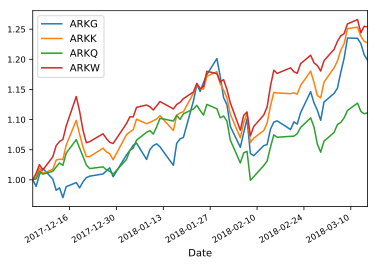

In [5]:
compound(px_etfs).plot(fontsize='small') # exclude from long strat the negative sectors?

In [6]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)
    px_etfs = load_pricing(universe + '.csv', 'Date')
    px_spy = load_pricing('SPY.csv', 'Date')

In [7]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for ARKG-hold-pricing.csv, with shape (69, 36)
Loaded pricing for ARKK-hold-pricing.csv, with shape (69, 55)
Loaded pricing for ARKQ-hold-pricing.csv, with shape (69, 45)
Loaded pricing for ARKW-hold-pricing.csv, with shape (69, 43)


#### Generate Trading Recomendations

In [8]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px=consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px=consol_px[:-1]
consol_px.tail(2)

,AAPL,ADBE,ADSK,AKAM,ALB,ALGN,ALNY,AMOT,AMZN,ANSS,...,TSLA,TSM,TWLO,TWOU,TWTR,VCYT,VLKAY,WMT,XLNX,XONE
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-13,179.970001,219.759995,136.000000,73.300003,102.794998,269.709991,144.160004,32.630001,1588.180054,167.750000,...,341.839996,44.990002,39.570000,84.720001,34.110001,6.39,38.650002,88.300003,76.139999,9.25
2018-03-14,178.440002,218.440002,136.190002,73.250000,100.330002,272.480011,141.830002,31.930000,1591.000000,166.949997,...,326.630005,45.150002,40.790001,87.720001,36.599998,6.24,39.750000,87.669998,76.010002,9.05


In [9]:
# range of potential gammas using logspace
SAMPLES = 100; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
gamma_val, gamma_sr = quick_gamma(
    gamma_vals, consol_px, hist_window, lb, 
    frequency, min_gross, max_gross, min_w, max_w)
gamma_val, gamma_sr

(24.20128264794381, 2.2220030332486038)

In [10]:
# Creates matrix of lookbacks and weights to determine the best combination
lbs = [x for x in range(5, 60, 5)]
ws = [y/100 for y in [x for x in range(5, 20, 5)]]

mtx_cols = ["Lookback", "Weight", "Return", "Risk", "Sharpe"]
mtx_df = pd.DataFrame([], index=range(len(lbs) * len(ws)), columns=mtx_cols)

log = True; i = 0
for l in lbs:
    for w in ws:
        px_portion, _, alloc, _ = recommend_allocs(
            consol_px, hist_window, l, frequency, min_gross, max_gross, min_w, w, gamma_val)
        rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
        ret, risk = port_metrics(px_portion, rec)
        mtx_df.loc[i][mtx_cols] = [l, w, ret, risk, ret / risk]
        i += 1

In [11]:
mtx_df = mtx_df.sort_values(by='Return', ascending=False)
lb, max_w = mtx_df.iloc[0]['Lookback'], mtx_df.iloc[0]['Weight']
print("Gamma: {0:.2f}, Lookback: {1}, Max Weight: {2}".format(gamma_val, lb, max_w))

Gamma: 24.20, Lookback: 15, Max Weight: 0.05


In [12]:
# run optimization with best gamma, returns initial weights
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, hist_window, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, 0.01)
tickers = rec.index.tolist()
recommend = rec.copy()
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
ADSK,0.050000,ARKK,AUTODESK INC
AKAM,0.050000,ARKW,AKAMAI TECHNOLOGIES INC
BLUE,0.031106,ARKG,BLUEBIRD BIO INC
CERS,0.050000,ARKG,CERUS CORP
CGEN,0.050000,ARKG,COMPUGEN LTD
CRM,0.050000,ARKK,SALESFORCE.COM INC
CRSP,0.050000,ARKG,CRISPR THERAPEUTICS AG
FMI,0.050000,ARKG,FOUNDATION MEDICINE INC
FPRX,0.022220,ARKG,FIVE PRIME THERAPEUTICS INC
HDP,0.050000,ARKK,HORTONWORKS INC


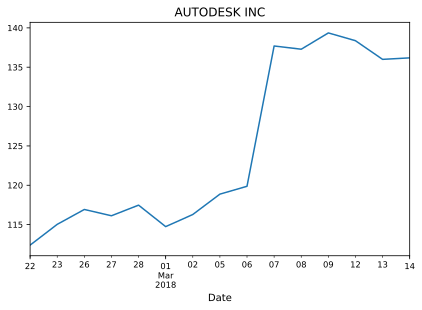

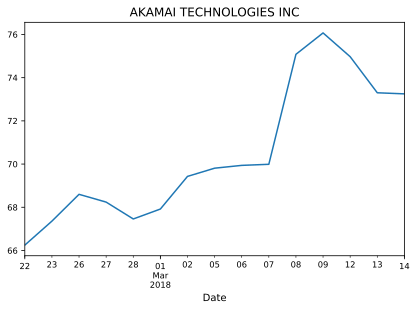

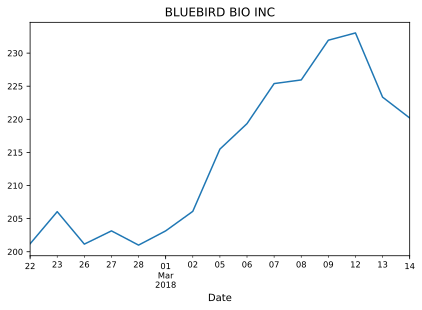

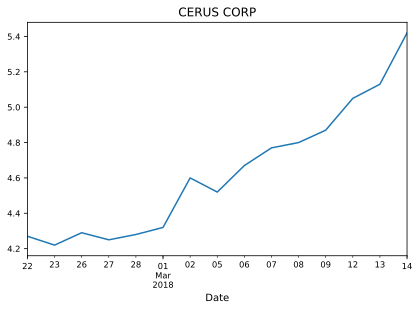

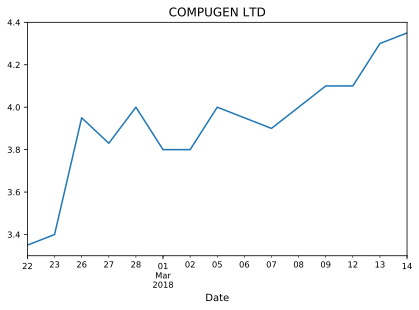

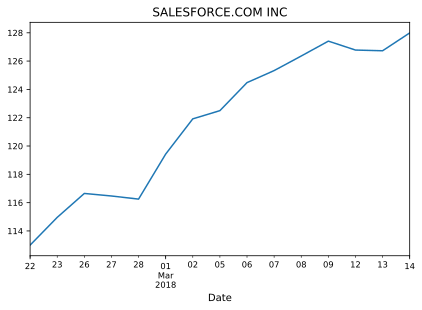

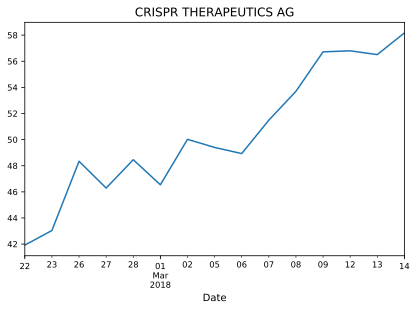

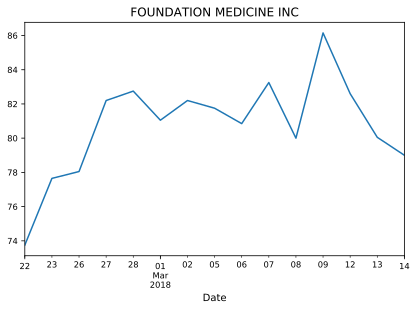

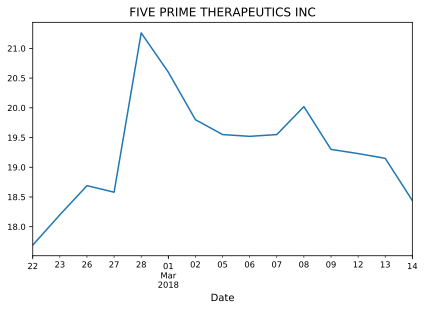

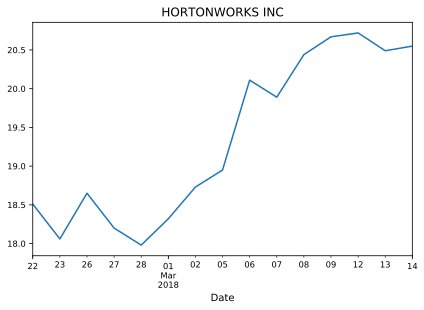

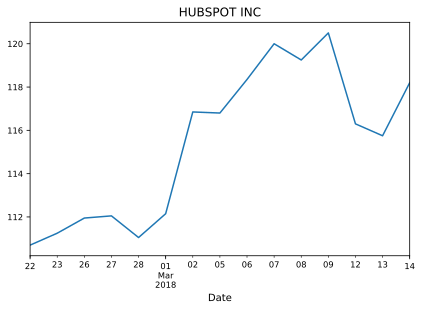

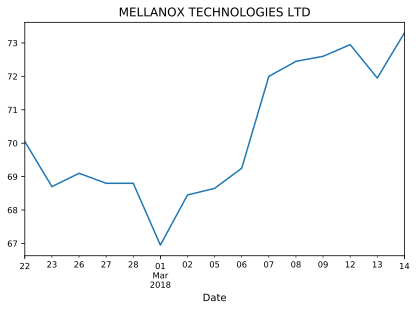

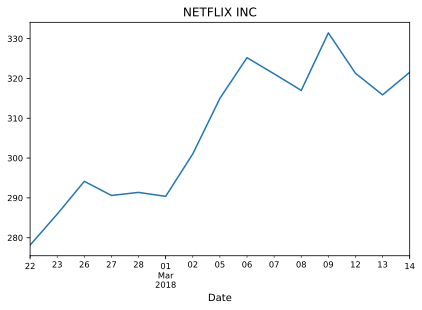

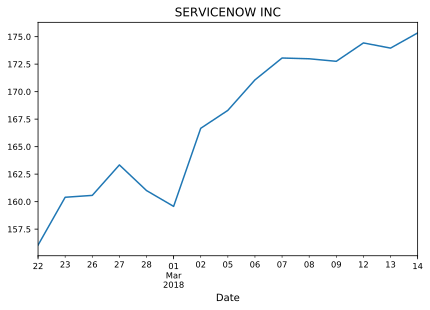

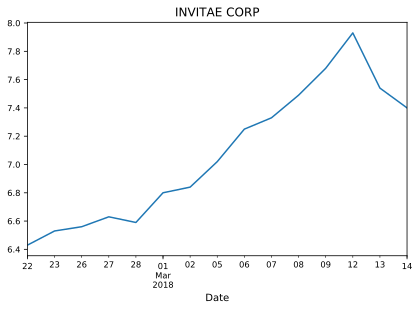

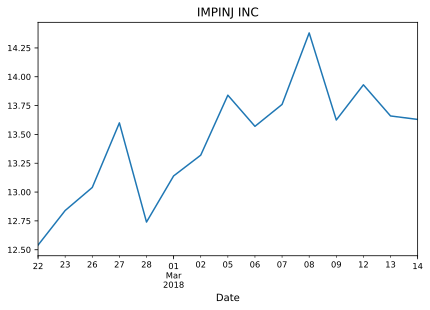

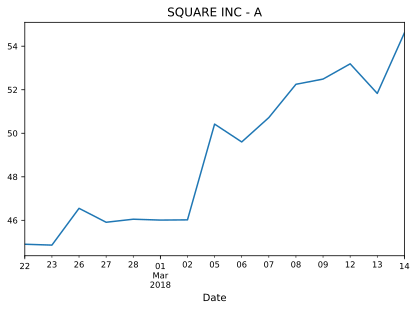

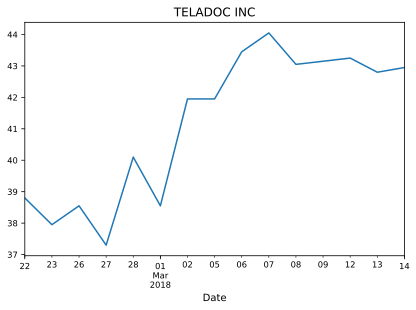

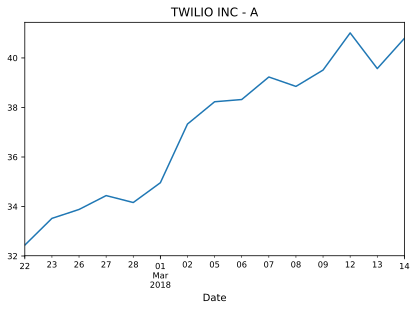

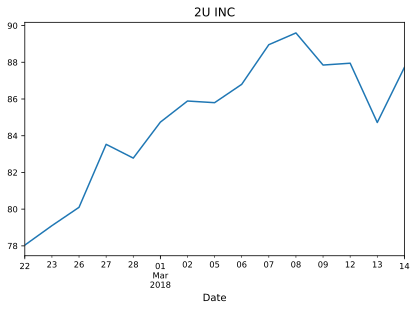

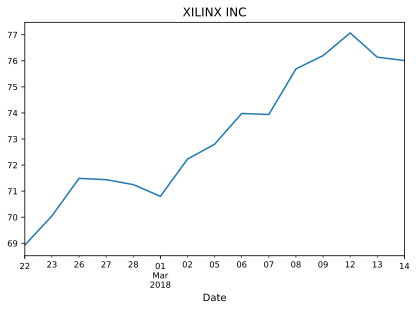

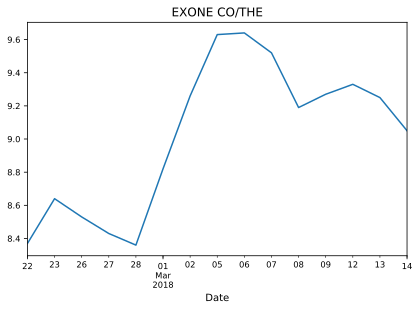

In [13]:
# plots all tickers to verify if there are any M&A targets
for t in recommend.sort_index().index:
    fig, ax = plt.subplots()
    plt.title(cos_no_dup.loc[t]['Company'])
    df_range = consol_px[t][-lb:]
    #dates = df_range.index.to_datetime()
    #values = df_range.values.tolist()
    #plt.plot(dates, values)
    #plt.xticks(np.arange(0, len(dates)), dates, rotation=45)
    fig.tight_layout()
    df_range.plot(fontsize='small')
    plt.show()

In [14]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation 100.00


,Sector Weight,Avg Position
ARKK,0.400000,0.050000
ARKG,0.303325,0.043332
ARKW,0.296675,0.042382


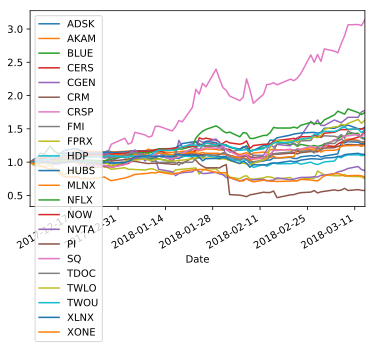

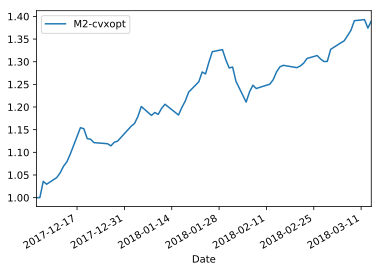

In [15]:
compound(consol_px[recommend.index][-hist_window:]).plot()
pdf.plot()

In [16]:
# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=rec.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 231000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.to_csv(universe+"-trading-df.csv")
trading_df.sort_index()


Time Window: 100, Lookback: 15, MinGross: 0.5, MaxGross: 1, MinWeight: 0, MaxWeight: 0.05
Ann. Ret: 0.11, Risk: 0.07 Sharpe: 1.53
Date: 2018-03-14, Total Invested: 231000.00, Total Allocation: 100.00%


,Company,Price,Allocation,Dollar Value,Shares
ADSK,AUTODESK INC,136.190002,0.050000,11549,84
AKAM,AKAMAI TECHNOLOGIES INC,73.250000,0.050000,11549,157
BLUE,BLUEBIRD BIO INC,220.199997,0.031106,7185,32
CERS,CERUS CORP,5.420000,0.050000,11549,2130
CGEN,COMPUGEN LTD,4.350000,0.050000,11549,2655
CRM,SALESFORCE.COM INC,127.989998,0.050000,11549,90
CRSP,CRISPR THERAPEUTICS AG,58.169998,0.050000,11549,198
FMI,FOUNDATION MEDICINE INC,79.000000,0.050000,11549,146
FPRX,FIVE PRIME THERAPEUTICS INC,18.440001,0.022220,5132,278
HDP,HORTONWORKS INC,20.549999,0.050000,11549,562
